TOPIC EXTRACTION FROM FEEDBACK FORMS ON TRAIN SERVICE IN UK

In [15]:
import json
from operator import itemgetter
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gensim
from gensim import corpora, models
from gensim.models import TfidfModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import string
import pyLDAvis.gensim_models
from itertools import chain

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Devadath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Devadath\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Importing and Sorting data with respect to time

In [2]:
data = json.load(open(r"C:\Users\Devadath\Desktop\Okra\train_reviews.json"))
data.sort(key = itemgetter('date'), reverse = True)

DATA PROCESSING

A function is bult to clean the text data provided. This involves removing stopwords and punctuation marks. Furthermore, resulting text sentences are lemmatized and the words are outputted in the form of a list.

In [3]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

Duplicate entries of the data need to be removed. This includes removal of identical dictionaries in the input data file. Furthermore, certain identical data points are recovered from different web pages. These duplicates are also identified and removed, resulting in a clean data frame of ideal input data. Furthermore, the given data contains feedback in dictionaries comprised of date and time of the feedback, rating, title and text, and the url from which is it extracted. However, we are only interested in the date and time, and the text in the feedback forms. Hence, the clean data frame only contains these categories.

In [4]:
memo = set()

ratings_counter = [0]*5 #To see the distribution of star rating within the input data

lem_text_df = pd.DataFrame(columns = ['Date&Time', 'Lem_Text'])

for entry in data:      
    if entry["text"] not in memo: # testing for already present value        
        rating = re.findall(r'[1-5]', entry["stars"])
        rating = int(rating[0])
        ratings_counter[rating-1] = ratings_counter[rating-1] + 1
        
        lem_text_df = lem_text_df.append({'Date&Time' : entry["date"], 'Lem_Text' : clean(entry["text"])}, ignore_index = True)

        memo.add(entry["text"]) # adding in memo if new value

Visualizing the distribution of ratings in the input feedback file. As can be seen, most of the reviews are 1-star and barely any of the feedback are 4 and 5-star. This helps us assume that most of the feedback forms are of negative tone and this assumption aids in characterizing the topics later on.

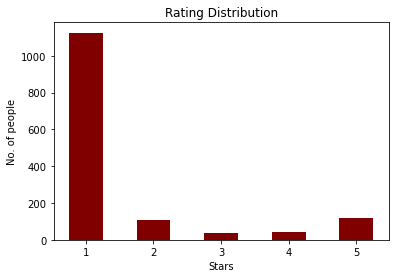

In [5]:
plt.bar(range(1, 6), ratings_counter, color = 'maroon', width = 0.5)
 
plt.xlabel("Stars")
plt.ylabel("No. of people")
plt.title("Rating Distribution")
plt.show()

The final step of the data processing to create bigrams from the above list of lemmatized data. This helps in preventing the individual influence of terms which are often used together, thereby improving the performance of clustering.

In [6]:
bigram = gensim.models.Phrases(lem_text_df['Lem_Text'], min_count = 10, threshold = 10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

lem_text_bigrams = make_bigrams(lem_text_df['Lem_Text'])

TOPIC EXTRACTION

LDA is applied on the processed data to form clusters, and each cluster represents a topic. Additionally, TF-IDF is implemented to nerf the influence of words which appear at a high frequency but have negligible impact on the topic. An example of this scenario is the word train. Since the feedback is based on the train system of UK, the word train is bound to appear multiple times but the impact of that word in this specific scenario is not expected to be much.

In [7]:
def lda_spec(text,num_topics): #Since the data is unsupervised, number of topics have to be decided by the user
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(doc) for doc in text ]
    tfidf = models.TfidfModel(corpus, id2word = dictionary)
    
    low_value = 0.075 #Words with frequency higher than this are nerfed
    
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]        
        corpus[i] = new_bow #reassign  

    lda = gensim.models.ldamodel.LdaModel # Instantiate LDA model
    ldamodel = lda(corpus, num_topics = num_topics, id2word = dictionary, passes = 50, minimum_probability = 0) # Fit LDA model on the dataset
    lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics = True, mds = 'mmds') # Visualize the LDA model results
    
    return lda_display

RESULTS

Firstly, let us examine he topic extraction performed on the entire dataset of 1437 feedback forms. The total number of clusters that be generated without a direct overlap of information is 9. However, due to the size of the data set and similarity between the possible topics, the results with 9 clusters does not lead to conclusive topics. Hence, let us try to cluster the data into 5 topics. The results can be seen below. 

It can be seen that the biggest topic can be accounted to bad customer service. Words like 'service', 'customer_service', 'staff', 'rude' and 'terrible' are indicative of the topic. The second biggest topic is related to the trains getting delayed and cancelled. This can be accounted to the fact that the second biggest cluster consists of words like 'cancelled', 'late' and 'delayed' on the top positions. The third biggest topic is related to poor online services as indicated by 'refund', 'website', 'email' and many other related terms. Fourth major topic is related to the complaints pertaining to the first class of the trains. This is suggested by the words 'eurostar', 'virgin_train' and 'first_class' as can be seen in the list of relevant terms. The last and smallest cluster seems abstract with most of the terms being generic. Hence, it is safe to assume that the topics extracted from the feedback form are of 4 types as described above.

In [13]:
print("Total number of feedback forms analysed is ", len(lem_text_bigrams))

lda_complete = lda_spec(lem_text_bigrams, 5)
pyLDAvis.display(lda_complete)

Total number of feedback forms analysed is  1437


Now let us examine the topics and the frequency with which they are reported with respect to year. Firstly, the data submitted in 2018 is extracted and a similar analysis as above is performed on the 536 entries. 

The topics extracted from the 2018 data seem to be similar to that of the above. However, the division or the separation between the topics is poor compared to when the whole dataset is used. This can be accounted to the fact that the size of the input dataset is almost reduced to 33% of the initial. However, the biggest topic is related to that of delays and cancellations and the second biggest topic seems to relate to customer service. The number of tokens allocated to both these topics does not differ by much though. Also, the number of key descriptive terms have reduced, and this can be accounted to the reduced data set size. As above, the third biggest topic is related to refunds and online services and the 4th biggest being the service with respect to first class and specific train companies. Fifth cluster does not define any clear topic as the combination of the words do not describe any specific problem or scenario.

In [14]:
lem_text_df_2018 = lem_text_df[lem_text_df['Date&Time'].str.contains('2018')]
lem_text_bigrams_2018 = make_bigrams(lem_text_df_2018['Lem_Text'])

print("No. of feedback forms received in 2018 is ", len(lem_text_bigrams_2018))

lda_2018 = lda_spec(lem_text_bigrams_2018, 5)
pyLDAvis.display(lda_2018)

No. of feedback forms received in 2018 is  536


Like above, let us analyse the 545 feedback forms received in the year 2017. As in 2018 the highest number of complaints are about cancellations and delays but with a slightly higher frequency as indicated by the tokens and the second biggest topic is the poor customer service. The third biggest cluster is associated with specific problems related to different train companies. The fourth topic refers to refunds and associated customer service but with the lowest frequency of occurrence. The fourth biggest cluster to which nearly 20% of the tokens are assigned is abstract and do not infer a specific topic.

In [10]:
lem_text_df_2017 = lem_text_df[lem_text_df['Date&Time'].str.contains('2017')]
lem_text_bigrams_2017 = make_bigrams(lem_text_df_2017['Lem_Text'])

print("No. of feedback forms received in 2017 is ", len(lem_text_bigrams_2017))

lda_2017 = lda_spec(lem_text_bigrams_2017, 5)
pyLDAvis.display(lda_2017)

No. of feedback forms received in 2017 is  545


There are only 286 feedback forms for the year 2016. This makes the distinction between the clusters poorer and hence reduced clarity in the topic descriptions. The biggest cluster indicates a topic related to prices and changes in the tickets of the train. This is deduced by the high weightage of words like 'price', 'change' and 'cost'. Second biggest topic is about the problems of first class and train carriers. Delays and cancellations are the third biggest topic of complaints which is a deviation in ranking from above. The fourth cluster contains words like 'booking' and 'book' along with terms related to service and complaints. This seems to indicate a new topic with respect to booking of the tickets. The fifth cluster infers a problem related to refunds and payments.

In [11]:
lem_text_df_2016 = lem_text_df[lem_text_df['Date&Time'].str.contains('2016')]
lem_text_bigrams_2016 = make_bigrams(lem_text_df_2016['Lem_Text'])

print("No. of feedback forms received in 2016 is ", len(lem_text_bigrams_2016))

lda_2016 = lda_spec(lem_text_bigrams_2016, 5)
pyLDAvis.display(lda_2016)

No. of feedback forms received in 2016 is  286


2015 has just 68 forms and the situation is same as 2016. A lot of key words in the clusters don't add much to derive a topic. For instance, in all the clusters, words like 'appreciate', 'man', 'problem' among others have high weightage. It is not possible to nerf these words as the total amount of text available is very less. However, key terms related to topics deduced above can be found distributed among all the clusters. 

The data from 2011 is not analysed as only 2 feedbacks forms are available.

In [12]:
lem_text_df_2015 = lem_text_df[lem_text_df['Date&Time'].str.contains('2015')]
lem_text_bigrams_2015 = make_bigrams(lem_text_df_2015['Lem_Text'])

print("No. of feedback forms received in 2015 is ", len(lem_text_bigrams_2015))

lda_2015 = lda_spec(lem_text_bigrams_2015, 5)
pyLDAvis.display(lda_2015)

No. of feedback forms received in 2015 is  68
